In [41]:
import tensorflow as tf
import torch
import onnx
from onnx_tf.backend import prepare
from torchsummary import summary
import numpy as np
import cv2

import numpy as np
import os
import torch
import torch.nn.functional as F
import torch
import torch.nn as nn
import torch.nn.functional as F
import time
import tqdm


In [42]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import time

class BasicLayer(nn.Module):
	"""
	  Basic Convolutional Layer: Conv2d -> BatchNorm -> ReLU
	"""
	def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1, dilation=1, bias=False):
		super().__init__()
		self.layer = nn.Sequential(
									  nn.Conv2d( in_channels, out_channels, kernel_size, padding = padding, stride=stride, dilation=dilation, bias = bias),
									  nn.BatchNorm2d(out_channels, affine=False),
									  nn.ReLU(inplace = True),
									)

	def forward(self, x):
	  return self.layer(x)

class XFeatModel(nn.Module):
	"""
	   Implementation of architecture described in 
	   "XFeat: Accelerated Features for Lightweight Image Matching, CVPR 2024."
	"""

	def __init__(self):
		super().__init__()
		self.norm = nn.InstanceNorm2d(1)


		########### ⬇️ CNN Backbone & Heads ⬇️ ###########

		self.skip1 = nn.Sequential(	 nn.AvgPool2d(4, stride = 4),
			  						 nn.Conv2d (1, 24, 1, stride = 1, padding=0) )

		self.block1 = nn.Sequential(
										BasicLayer( 1,  4, stride=1),
										BasicLayer( 4,  8, stride=2),
										BasicLayer( 8,  8, stride=1),
										BasicLayer( 8, 24, stride=2),
									)

		self.block2 = nn.Sequential(
										BasicLayer(24, 24, stride=1),
										BasicLayer(24, 24, stride=1),
									 )

		self.block3 = nn.Sequential(
										BasicLayer(24, 64, stride=2),
										BasicLayer(64, 64, stride=1),
										BasicLayer(64, 64, 1, padding=0),
									 )
		self.block4 = nn.Sequential(
										BasicLayer(64, 64, stride=2),
										BasicLayer(64, 64, stride=1),
										BasicLayer(64, 64, stride=1),
									 )

		self.block5 = nn.Sequential(
										BasicLayer( 64, 128, stride=2),
										BasicLayer(128, 128, stride=1),
										BasicLayer(128, 128, stride=1),
										BasicLayer(128,  64, 1, padding=0),
									 )

		self.block_fusion =  nn.Sequential(
										BasicLayer(64, 64, stride=1),
										BasicLayer(64, 64, stride=1),
										nn.Conv2d (64, 64, 1, padding=0)
									 )

		self.heatmap_head = nn.Sequential(
										BasicLayer(64, 64, 1, padding=0),
										BasicLayer(64, 64, 1, padding=0),
										nn.Conv2d (64, 1, 1),
										nn.Sigmoid()
									)


		self.keypoint_head = nn.Sequential(
										BasicLayer(64, 64, 1, padding=0),
										BasicLayer(64, 64, 1, padding=0),
										BasicLayer(64, 64, 1, padding=0),
										nn.Conv2d (64, 65, 1),
									)


  		########### ⬇️ Fine Matcher MLP ⬇️ ###########

		self.fine_matcher =  nn.Sequential(
											nn.Linear(128, 512),
											nn.BatchNorm1d(512, affine=False),
									  		nn.ReLU(inplace = True),
											nn.Linear(512, 512),
											nn.BatchNorm1d(512, affine=False),
									  		nn.ReLU(inplace = True),
											nn.Linear(512, 512),
											nn.BatchNorm1d(512, affine=False),
									  		nn.ReLU(inplace = True),
											nn.Linear(512, 512),
											nn.BatchNorm1d(512, affine=False),
									  		nn.ReLU(inplace = True),
											nn.Linear(512, 64),
										)

	def _unfold2d(self, x, ws = 2):
		"""
			Unfolds tensor in 2D with desired ws (window size) and concat the channels
		"""
		B, C, H, W = x.shape
		x = x.unfold(2,  ws , ws).unfold(3, ws,ws)                             \
			.reshape(B, C, H//ws, W//ws, ws**2)
		return x.permute(0, 1, 4, 2, 3).reshape(B, -1, H//ws, W//ws)


	def forward(self, x):
		"""
			input:
				x -> torch.Tensor(B, C, H, W) grayscale or rgb images
			return:
				feats     ->  torch.Tensor(B, 64, H/8, W/8) dense local features
				keypoints ->  torch.Tensor(B, 65, H/8, W/8) keypoint logit map
				heatmap   ->  torch.Tensor(B,  1, H/8, W/8) reliability map

		"""
		#dont backprop through normalization
		with torch.no_grad():
			x = x.mean(dim=1, keepdim = True)
			x = self.norm(x)

		#main backbone
		x1 = self.block1(x)
		x2 = self.block2(x1 + self.skip1(x))
		x3 = self.block3(x2)
		x4 = self.block4(x3)
		x5 = self.block5(x4)

		#pyramid fusion
		x4 = F.interpolate(x4, (x3.shape[-2], x3.shape[-1]), mode='bilinear')
		x5 = F.interpolate(x5, (x3.shape[-2], x3.shape[-1]), mode='bilinear')
		feats = self.block_fusion( x3 + x4 + x5 )

		#heads
		heatmap = self.heatmap_head(feats) # Reliability map
		keypoints = self.keypoint_head(self._unfold2d(x, ws=8)) #Keypoint map logits

		return feats, keypoints, heatmap


In [43]:
# Load ONNX model and convert to TensorFlow format
model_onnx = onnx.load('./weights/xfeat_matching.onnx')

tf_rep = prepare(model_onnx)
# Export model as .pb file
tf_rep.export_graph('./weights/xfeat.pb')

INFO:absl:Function `__call__` contains input name(s) x, y, tensor with unsupported characters which will be renamed to transpose_348_x, mul_63_y, reshape_47_tensor in the SavedModel.
INFO:absl:Found untraced functions such as gen_tensor_dict while saving (showing 1 of 1). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ./weights/xfeat.pb/assets


INFO:tensorflow:Assets written to: ./weights/xfeat.pb/assets
INFO:absl:Writing fingerprint to ./weights/xfeat.pb/fingerprint.pb


In [56]:
model_dir = './weights/xfeat.pb'  # Path to the saved model directory
model = tf.saved_model.load(model_dir)


In [45]:
print("Available functions:")
for func in model.signatures:
    print(func)

Available functions:
serving_default


In [57]:
# Access the default serving function
infer = model.signatures['serving_default']

# Print input and output details
print("Inputs:")
for input_tensor in infer.inputs:
    print(f"{input_tensor.name}: {input_tensor.shape}")

print("Outputs:")
for output_tensor in infer.outputs:
    print(f"{output_tensor.name}: {output_tensor.shape}")

Inputs:
images0:0: (None, 3, None, None)
images1:0: (None, 3, None, None)
unknown:0: (4,)
unknown_0:0: (4,)
unknown_1:0: ()
unknown_2:0: ()
unknown_3:0: ()
unknown_4:0: (1,)
unknown_5:0: (1,)
unknown_6:0: (1,)
unknown_7:0: (1,)
unknown_8:0: (4, 1, 3, 3)
unknown_9:0: (4,)
unknown_10:0: (8, 4, 3, 3)
unknown_11:0: (8,)
unknown_12:0: (8, 8, 3, 3)
unknown_13:0: (8,)
unknown_14:0: (24, 8, 3, 3)
unknown_15:0: (24,)
unknown_16:0: (24, 1, 1, 1)
unknown_17:0: (24,)
unknown_18:0: (24, 24, 3, 3)
unknown_19:0: (24,)
unknown_20:0: (24, 24, 3, 3)
unknown_21:0: (24,)
unknown_22:0: (64, 24, 3, 3)
unknown_23:0: (64,)
unknown_24:0: (64, 64, 3, 3)
unknown_25:0: (64,)
unknown_26:0: (64, 64, 1, 1)
unknown_27:0: (64,)
unknown_28:0: (64, 64, 3, 3)
unknown_29:0: (64,)
unknown_30:0: (64, 64, 3, 3)
unknown_31:0: (64,)
unknown_32:0: (64, 64, 3, 3)
unknown_33:0: (64,)
unknown_34:0: (128, 64, 3, 3)
unknown_35:0: (128,)
unknown_36:0: (128, 128, 3, 3)
unknown_37:0: (128,)
unknown_38:0: (128, 128, 3, 3)
unknown_39:0: 

In [58]:
# Get the concrete function from the model
concrete_func = model.signatures['serving_default']

# Print graph details
print("Concrete function details:")
print(concrete_func.graph.as_graph_def())


Concrete function details:
node {
  name: "images0"
  op: "Placeholder"
  attr {
    key: "shape"
    value {
      shape {
        dim {
          size: -1
        }
        dim {
          size: 3
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
      }
    }
  }
  attr {
    key: "dtype"
    value {
      type: DT_FLOAT
    }
  }
  attr {
    key: "_user_specified_name"
    value {
      s: "images0"
    }
  }
}
node {
  name: "images1"
  op: "Placeholder"
  attr {
    key: "shape"
    value {
      shape {
        dim {
          size: -1
        }
        dim {
          size: 3
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
      }
    }
  }
  attr {
    key: "dtype"
    value {
      type: DT_FLOAT
    }
  }
  attr {
    key: "_user_specified_name"
    value {
      s: "images1"
    }
  }
}
node {
  name: "unknown"
  op: "Placeholder"
  attr {
    key: "shape"
    value {
      shape 

In [59]:
import tensorflow as tf
import numpy as np

# Load SavedModel
model = tf.saved_model.load('./weights/xfeat.pb')

# Get the inference function from the model
infer = model.signatures["serving_default"]

im1 = cv2.imread('./assets/ref2.png')
im2 = cv2.imread('./assets/tgt2.png')

# Prepare the inputs
input_array_1 = im1.transpose(2, 0, 1).astype(np.float32)
input_array_1 = np.expand_dims(input_array_1, axis=0)
input_array_2 = im2.transpose(2, 0, 1).astype(np.float32)
input_array_2 = np.expand_dims(input_array_2, axis=0)

# Create batch
batch_size = 1
input_array_1 = np.concatenate([input_array_1 for _ in range(batch_size)], axis=0)
input_array_2 = np.concatenate([input_array_2 for _ in range(batch_size)], axis=0)

print(f"Input shape: {input_array_1.shape}")
# Feed inputs to the model
inputs = {
    "images0": tf.convert_to_tensor(input_array_1),  # Adjust name based on signature
    "images1": tf.convert_to_tensor(input_array_2)   # Adjust name based on signature
}

# Run inference
output = infer(**inputs)

#print(output)

# Extract and print the output
output_tensor = output['matches'].numpy()  # Adjust name based on signature
#print("Model output:", output_tensor)


Input shape: (1, 3, 480, 640)


In [60]:
# Validate the outputs of the psuedo-batched inputs
matches = output['matches']
batch_indexes = output['batch_indexes']

matches_0 = matches[batch_indexes == 0]
valid = []
for i in range(1, input_array_1.shape[0]):
    valid.append(np.all(matches_0 == matches[batch_indexes == i]))
print(f"equal: {valid}")

equal: []


In [61]:
def warp_corners_and_draw_matches(ref_points, dst_points, img1, img2):
    # Calculate the Homography matrix
    H, mask = cv2.findHomography(ref_points, dst_points, cv2.USAC_MAGSAC, 3.5, maxIters=1_000, confidence=0.999)
    mask = mask.flatten()

    # Get corners of the first image (image1)
    h, w = img1.shape[:2]
    corners_img1 = np.array([[0, 0], [w-1, 0], [w-1, h-1], [0, h-1]], dtype=np.float32).reshape(-1, 1, 2)

    # Warp corners to the second image (image2) space
    warped_corners = cv2.perspectiveTransform(corners_img1, H)

    # Draw the warped corners in image2
    img2_with_corners = img2.copy()
    for i in range(len(warped_corners)):
        start_point = tuple(warped_corners[i-1][0].astype(int))
        end_point = tuple(warped_corners[i][0].astype(int))
        cv2.line(img2_with_corners, start_point, end_point, (0, 255, 0), 4)  # Using solid green for corners

    # Prepare keypoints and matches for drawMatches function
    keypoints1 = [cv2.KeyPoint(p[0], p[1], 5) for p in ref_points]
    keypoints2 = [cv2.KeyPoint(p[0], p[1], 5) for p in dst_points]
    matches = [cv2.DMatch(i,i,0) for i in range(len(mask)) if mask[i]]

    # Draw inlier matches
    img_matches = cv2.drawMatches(img1, keypoints1, img2_with_corners, keypoints2, matches, None,
                                  matchColor=(0, 255, 0), flags=2)

    return img_matches

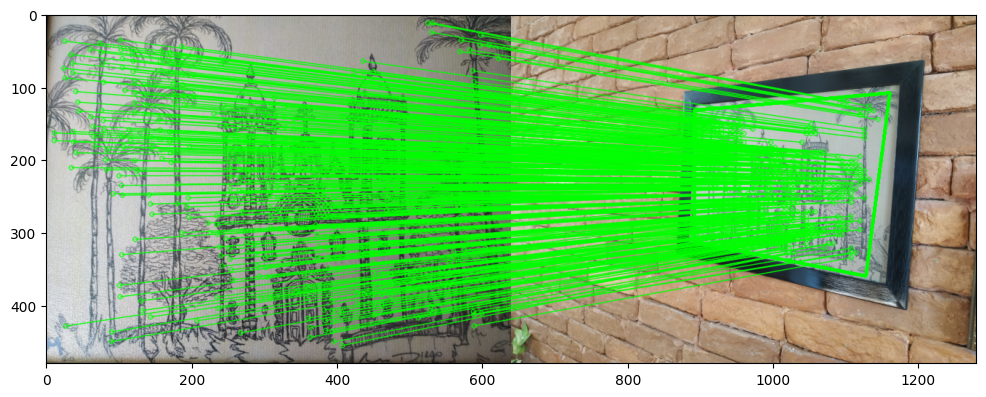

In [62]:
import matplotlib.pyplot as plt
matches = output['matches'].numpy()
batch_indexes = output['batch_indexes'].numpy()
mkpts_0, mkpts_1 = matches[batch_indexes == 0][..., :2], matches[batch_indexes == 0][..., 2:]

canvas = warp_corners_and_draw_matches(mkpts_0, mkpts_1, im1, im2)
plt.figure(figsize=(12,12))
plt.imshow(canvas[..., ::-1])
plt.show()

In [75]:
# model = tf.saved_model.load('./weights/xfeat.pb')
# concrete_func = model.signatures[
#   tf.saved_model.DEFAULT_SERVING_SIGNATURE_DEF_KEY]
# concrete_func.inputs[0].set_shape([1, 3, 480, 640])
# concrete_func.inputs[1].set_shape([1, 3, 480, 640])
# converter = tf.lite.TFLiteConverter.from_concrete_functions([concrete_func])
# converter.target_spec.supported_ops = [
#   tf.lite.OpsSet.TFLITE_BUILTINS, # enable LiteRT ops.
#   tf.lite.OpsSet.SELECT_TF_OPS # enable TensorFlow ops.
# ]

# tflite_model = converter.convert()

import tensorflow as tf
import numpy as np

def convert_and_quantize_model(input_model_path, output_model_path):
    # Load the saved model
    model = tf.saved_model.load(input_model_path)
    concrete_func = model.signatures[tf.saved_model.DEFAULT_SERVING_SIGNATURE_DEF_KEY]
    
    # Set input shapes
    concrete_func.inputs[0].set_shape([1, 3, 480, 640])
    concrete_func.inputs[1].set_shape([1, 3, 480, 640])
    
    # Create a TFLite converter
    converter = tf.lite.TFLiteConverter.from_concrete_functions([concrete_func])
    
    # Set supported ops
    converter.target_spec.supported_ops = [
        tf.lite.OpsSet.TFLITE_BUILTINS,
        tf.lite.OpsSet.SELECT_TF_OPS
    ]
    
    # Enable quantization
    converter.optimizations = [tf.lite.Optimize.DEFAULT]
    
    # Define a representative dataset generator
    def representative_dataset_gen():
        for _ in range(100):
            # Generate dummy input data matching your model's input shape
            yield [
                np.random.rand(1, 3, 480, 640).astype(np.float32),
                np.random.rand(1, 3, 480, 640).astype(np.float32)
            ]
    
    # Set the representative dataset
    converter.representative_dataset = representative_dataset_gen
    
    # Convert the model
    tflite_model = converter.convert()
    
    # Save the quantized model
    with open(output_model_path, 'wb') as f:
        f.write(tflite_model)

# Usage
input_model_path = './weights/xfeat.pb'
output_model_path = './weights/quantized_xfeat.tflite'
convert_and_quantize_model(input_model_path, output_model_path)

2024-09-21 07:28:54.118541: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-09-21 07:28:54.118731: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2024-09-21 07:28:54.118925: I tensorflow/core/grappler/clusters/single_machine.cc:357] Starting new session
2024-09-21 07:28:54.119213: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-09-21 07:28:54.119353: W tensorflow/core/common_runtime/gpu/gpu_d

In [52]:
# # Save the model.
# with open('xfeat.tflite', 'wb') as f:
#   f.write(tflite_model)

In [80]:
# Load the TensorFlow Lite model into memory
# interpreter = tf.lite.Interpreter(model_content=tflite_model)

# # Allocate tensors (mandatory before inference)
# interpreter.allocate_tensors()

# # Get input and output details
# input_details = interpreter.get_input_details()
# output_details = interpreter.get_output_details()

# print("Input details:", input_details)
# print("Output details:", output_details)

# # Prepare the inputs (ensure input format matches model requirements)
# input_array_1 = im1.transpose(2, 0, 1).astype(np.float32)
# input_array_1 = np.expand_dims(input_array_1, axis=0)
# input_array_2 = im2.transpose(2, 0, 1).astype(np.float32)
# input_array_2 = np.expand_dims(input_array_2, axis=0)

# # Batch the input data if necessary
# batch_size = 1
# input_array_1 = np.concatenate([input_array_1 for _ in range(batch_size)], axis=0)
# input_array_2 = np.concatenate([input_array_2 for _ in range(batch_size)], axis=0)

# # Set the input tensor
# interpreter.set_tensor(input_details[0]['index'], input_array_1)
# interpreter.set_tensor(input_details[1]['index'], input_array_2)

# # Run inference
# interpreter.invoke()

# # Get the output tensor
# output = interpreter.get_tensor(output_details[1]['index'])  # Adjust output index as needed

# # Print the output
# print("Model output:", output)

import tensorflow as tf
import numpy as np

# Load the converted and quantized TensorFlow Lite model
interpreter = tf.lite.Interpreter(model_path="/home/abdurrehman-subhani/development/aarjit/accelerated_features/weights/quantized_xfeat.tflite")

# Allocate tensors (mandatory before inference)
interpreter.allocate_tensors()

# Get input and output details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print("Input details:", input_details)
print("Output details:", output_details)

# Prepare the inputs (ensure input format matches model requirements)
# Replace this with your actual input data preparation
im1 = np.random.rand(480, 640, 3).astype(np.float32)
im2 = np.random.rand(480, 640, 3).astype(np.float32)

input_array_1 = im1.transpose(2, 0, 1).astype(np.float32)
input_array_1 = np.expand_dims(input_array_1, axis=0)
input_array_2 = im2.transpose(2, 0, 1).astype(np.float32)
input_array_2 = np.expand_dims(input_array_2, axis=0)

# Batch the input data if necessary
batch_size = 1
input_array_1 = np.concatenate([input_array_1 for _ in range(batch_size)], axis=0)
input_array_2 = np.concatenate([input_array_2 for _ in range(batch_size)], axis=0)

# Set the input tensor
interpreter.set_tensor(input_details[0]['index'], input_array_1)
interpreter.set_tensor(input_details[1]['index'], input_array_2)

# Run inference
interpreter.invoke()

# Get the output tensor
output = interpreter.get_tensor(output_details[1]['index'])  # Adjust output index as needed

# Print the output
print("Model output:", output)

Input details: [{'name': 'images0', 'index': 0, 'shape': array([  1,   3, 480, 640], dtype=int32), 'shape_signature': array([  1,   3, 480, 640], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}, {'name': 'images1', 'index': 1, 'shape': array([  1,   3, 480, 640], dtype=int32), 'shape_signature': array([  1,   3, 480, 640], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
Output details: [{'name': 'Identity', 'index': 902, 'shape': array([1], dtype=int32), 'shape_signature': array([-1], dtype=int32), 'dtype': <class 'numpy.int64'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_p

In [81]:
import matplotlib.pyplot as plt
matches = interpreter.get_tensor(output_details[1]['index'])
batch_indexes = interpreter.get_tensor(output_details[0]['index'])
mkpts_0, mkpts_1 = matches[batch_indexes == 0][..., :2], matches[batch_indexes == 0][..., 2:]

canvas = warp_corners_and_draw_matches(mkpts_0, mkpts_1, im1, im2)
plt.figure(figsize=(12,12))
plt.imshow(canvas[..., ::-1])
plt.show()

error: OpenCV(4.10.0) /io/opencv/modules/features2d/src/draw.cpp:127: error: (-2:Unspecified error) in function 'void cv::_prepareImage(cv::InputArray, const cv::Mat&)'
> Unsupported source image:
>     'src.type() == CV_8UC1 || src.type() == CV_8UC3 || src.type() == CV_8UC4'
> where
>     'src.type()' is 21 (CV_32FC3)


Input details: [{'name': 'images0', 'index': 0, 'shape': array([  1,   3, 480, 640], dtype=int32), 'shape_signature': array([  1,   3, 480, 640], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}, {'name': 'images1', 'index': 1, 'shape': array([  1,   3, 480, 640], dtype=int32), 'shape_signature': array([  1,   3, 480, 640], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
Output details: [{'name': 'Identity', 'index': 902, 'shape': array([1], dtype=int32), 'shape_signature': array([-1], dtype=int32), 'dtype': <class 'numpy.int64'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_p

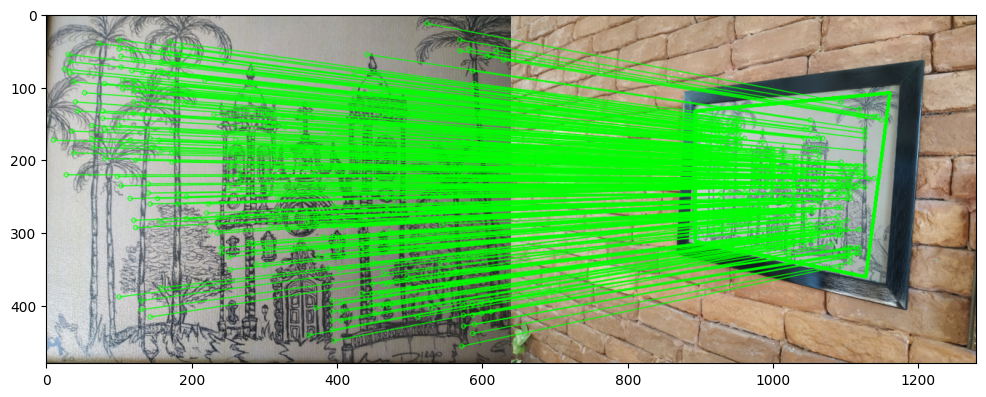

In [85]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Load images using OpenCV
im1 = cv2.imread('./assets/ref2.png')
im2 = cv2.imread('./assets/tgt2.png')

# Convert images from BGR to RGB
im1_rgb = cv2.cvtColor(im1, cv2.COLOR_BGR2RGB)
im2_rgb = cv2.cvtColor(im2, cv2.COLOR_BGR2RGB)

# Load the converted and quantized TensorFlow Lite model
interpreter = tf.lite.Interpreter(model_path="/home/abdurrehman-subhani/development/aarjit/accelerated_features/weights/quantized_xfeat.tflite")

# Allocate tensors (mandatory before inference)
interpreter.allocate_tensors()

# Get input and output details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print("Input details:", input_details)
print("Output details:", output_details)

# Prepare the inputs
input_array_1 = im1_rgb.transpose(2, 0, 1).astype(np.float32) / 255.0
input_array_1 = np.expand_dims(input_array_1, axis=0)
input_array_2 = im2_rgb.transpose(2, 0, 1).astype(np.float32) / 255.0
input_array_2 = np.expand_dims(input_array_2, axis=0)

# Set the input tensor
interpreter.set_tensor(input_details[0]['index'], input_array_1)
interpreter.set_tensor(input_details[1]['index'], input_array_2)

# Run inference
interpreter.invoke()

# Get the output tensor
matches = interpreter.get_tensor(output_details[1]['index'])
batch_indexes = interpreter.get_tensor(output_details[0]['index'])
mkpts_0, mkpts_1 = matches[batch_indexes == 0][..., :2], matches[batch_indexes == 0][..., 2:]

def warp_corners_and_draw_matches(ref_points, dst_points, img1, img2):
    # Calculate the Homography matrix
    H, mask = cv2.findHomography(ref_points, dst_points, cv2.USAC_MAGSAC, 3.5, maxIters=1_000, confidence=0.999)
    mask = mask.flatten()

    # Get corners of the first image (image1)
    h, w = img1.shape[:2]
    corners_img1 = np.array([[0, 0], [w-1, 0], [w-1, h-1], [0, h-1]], dtype=np.float32).reshape(-1, 1, 2)

    # Warp corners to the second image (image2) space
    warped_corners = cv2.perspectiveTransform(corners_img1, H)

    # Draw the warped corners in image2
    img2_with_corners = img2.copy()
    for i in range(len(warped_corners)):
        start_point = tuple(warped_corners[i-1][0].astype(int))
        end_point = tuple(warped_corners[i][0].astype(int))
        cv2.line(img2_with_corners, start_point, end_point, (0, 255, 0), 4)  # Using solid green for corners

    # Prepare keypoints and matches for drawMatches function
    keypoints1 = [cv2.KeyPoint(p[0], p[1], 5) for p in ref_points]
    keypoints2 = [cv2.KeyPoint(p[0], p[1], 5) for p in dst_points]
    matches = [cv2.DMatch(i,i,0) for i in range(len(mask)) if mask[i]]

    # Draw inlier matches
    img_matches = cv2.drawMatches(img1, keypoints1, img2_with_corners, keypoints2, matches, None,
                                  matchColor=(0, 255, 0), flags=2)

    return img_matches

canvas = warp_corners_and_draw_matches(mkpts_0, mkpts_1, im1, im2)
plt.figure(figsize=(12,12))
plt.imshow(cv2.cvtColor(canvas, cv2.COLOR_BGR2RGB))
plt.show()

In [86]:
import tensorflow as tf
import numpy as np

def representative_dataset_gen():
    # This function should yield representative data samples
    # You'll need to modify this to use your actual data
    for _ in range(100):
        yield [np.random.rand(1, 3, 480, 640).astype(np.float32),
               np.random.rand(1, 3, 480, 640).astype(np.float32)]

def convert_and_quantize_model(model_path, output_path):
    # Load the model
    model = tf.saved_model.load(model_path)
    concrete_func = model.signatures[tf.saved_model.DEFAULT_SERVING_SIGNATURE_DEF_KEY]
    
    # Create a TFLite converter
    converter = tf.lite.TFLiteConverter.from_concrete_functions([concrete_func])
    
    # Set optimization flags
    converter.optimizations = [tf.lite.Optimize.DEFAULT]
    converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
    converter.inference_input_type = tf.int8
    converter.inference_output_type = tf.int8
    
    # Set representative dataset
    converter.representative_dataset = representative_dataset_gen
    
    # Convert the model
    tflite_model = converter.convert()
    
    # Save the model
    with open(output_path, 'wb') as f:
        f.write(tflite_model)
    
    print(f"Quantized model saved to {output_path}")
    print(f"Model size: {len(tflite_model) / (1024 * 1024):.2f} MB")

# Usage
input_model_path = './weights/xfeat.pb'
output_model_path = './weights/quantized_xfeat_int8.tflite'
convert_and_quantize_model(input_model_path, output_model_path)

2024-09-21 07:42:34.919610: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-09-21 07:42:34.919790: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2024-09-21 07:42:34.919913: I tensorflow/core/grappler/clusters/single_machine.cc:357] Starting new session
2024-09-21 07:42:34.920171: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-09-21 07:42:34.920306: W tensorflow/core/common_runtime/gpu/gpu_d

ConverterError: <unknown>:0: error: loc(fused["RealDiv:", "onnx_tf_prefix_/Div@__inference___call___612628", "StatefulPartitionedCall/onnx_tf_prefix_/Div"]): 'tf.RealDiv' op is neither a custom op nor a flex op
<unknown>:0: note: loc(fused["RealDiv:", "onnx_tf_prefix_/Div@__inference___call___612628", "StatefulPartitionedCall/onnx_tf_prefix_/Div"]): Error code: ERROR_NEEDS_FLEX_OPS
<unknown>:0: error: loc(fused["RealDiv:", "onnx_tf_prefix_/Div_1@__inference___call___612628", "StatefulPartitionedCall/onnx_tf_prefix_/Div_1"]): 'tf.RealDiv' op is neither a custom op nor a flex op
<unknown>:0: note: loc(fused["RealDiv:", "onnx_tf_prefix_/Div_1@__inference___call___612628", "StatefulPartitionedCall/onnx_tf_prefix_/Div_1"]): Error code: ERROR_NEEDS_FLEX_OPS
<unknown>:0: error: loc(fused["Range:", "onnx_tf_prefix_/Range@__inference___call___612628", "StatefulPartitionedCall/onnx_tf_prefix_/Range"]): 'tf.Range' op is neither a custom op nor a flex op
<unknown>:0: note: loc(fused["Range:", "onnx_tf_prefix_/Range@__inference___call___612628", "StatefulPartitionedCall/onnx_tf_prefix_/Range"]): Error code: ERROR_NEEDS_FLEX_OPS
<unknown>:0: error: loc(fused["Range:", "onnx_tf_prefix_/Range_1@__inference___call___612628", "StatefulPartitionedCall/onnx_tf_prefix_/Range_1"]): 'tf.Range' op is neither a custom op nor a flex op
<unknown>:0: note: loc(fused["Range:", "onnx_tf_prefix_/Range_1@__inference___call___612628", "StatefulPartitionedCall/onnx_tf_prefix_/Range_1"]): Error code: ERROR_NEEDS_FLEX_OPS
<unknown>:0: error: loc(fused["Range:", "range_1@__inference___call___612628", "StatefulPartitionedCall/range_1"]): 'tf.Range' op is neither a custom op nor a flex op
<unknown>:0: note: loc(fused["Range:", "range_1@__inference___call___612628", "StatefulPartitionedCall/range_1"]): Error code: ERROR_NEEDS_FLEX_OPS
<unknown>:0: error: loc(fused["Range:", "range_2@__inference___call___612628", "StatefulPartitionedCall/range_2"]): 'tf.Range' op is neither a custom op nor a flex op
<unknown>:0: note: loc(fused["Range:", "range_2@__inference___call___612628", "StatefulPartitionedCall/range_2"]): Error code: ERROR_NEEDS_FLEX_OPS
<unknown>:0: error: loc(fused["Range:", "range_5@__inference___call___612628", "StatefulPartitionedCall/range_5"]): 'tf.Range' op is neither a custom op nor a flex op
<unknown>:0: note: loc(fused["Range:", "range_5@__inference___call___612628", "StatefulPartitionedCall/range_5"]): Error code: ERROR_NEEDS_FLEX_OPS
<unknown>:0: error: loc(fused["Range:", "range_6@__inference___call___612628", "StatefulPartitionedCall/range_6"]): 'tf.Range' op is neither a custom op nor a flex op
<unknown>:0: note: loc(fused["Range:", "range_6@__inference___call___612628", "StatefulPartitionedCall/range_6"]): Error code: ERROR_NEEDS_FLEX_OPS
<unknown>:0: error: loc(fused["Range:", "onnx_tf_prefix_Range_806@__inference___call___612628", "StatefulPartitionedCall/onnx_tf_prefix_Range_806"]): 'tf.Range' op is neither a custom op nor a flex op
<unknown>:0: note: loc(fused["Range:", "onnx_tf_prefix_Range_806@__inference___call___612628", "StatefulPartitionedCall/onnx_tf_prefix_Range_806"]): Error code: ERROR_NEEDS_FLEX_OPS
<unknown>:0: error: loc(fused["Range:", "onnx_tf_prefix_Range_813@__inference___call___612628", "StatefulPartitionedCall/onnx_tf_prefix_Range_813"]): 'tf.Range' op is neither a custom op nor a flex op
<unknown>:0: note: loc(fused["Range:", "onnx_tf_prefix_Range_813@__inference___call___612628", "StatefulPartitionedCall/onnx_tf_prefix_Range_813"]): Error code: ERROR_NEEDS_FLEX_OPS
<unknown>:0: error: loc(fused["Range:", "onnx_tf_prefix_Range_869@__inference___call___612628", "StatefulPartitionedCall/onnx_tf_prefix_Range_869"]): 'tf.Range' op is neither a custom op nor a flex op
<unknown>:0: note: loc(fused["Range:", "onnx_tf_prefix_Range_869@__inference___call___612628", "StatefulPartitionedCall/onnx_tf_prefix_Range_869"]): Error code: ERROR_NEEDS_FLEX_OPS
<unknown>:0: error: loc(fused["Range:", "onnx_tf_prefix_Range_876@__inference___call___612628", "StatefulPartitionedCall/onnx_tf_prefix_Range_876"]): 'tf.Range' op is neither a custom op nor a flex op
<unknown>:0: note: loc(fused["Range:", "onnx_tf_prefix_Range_876@__inference___call___612628", "StatefulPartitionedCall/onnx_tf_prefix_Range_876"]): Error code: ERROR_NEEDS_FLEX_OPS
<unknown>:0: error: loc(fused["RealDiv:", "onnx_tf_prefix_/Div_4@__inference___call___612628", "StatefulPartitionedCall/onnx_tf_prefix_/Div_4"]): 'tf.RealDiv' op is neither a custom op nor a flex op
<unknown>:0: note: loc(fused["RealDiv:", "onnx_tf_prefix_/Div_4@__inference___call___612628", "StatefulPartitionedCall/onnx_tf_prefix_/Div_4"]): Error code: ERROR_NEEDS_FLEX_OPS
<unknown>:0: error: loc(fused["RealDiv:", "onnx_tf_prefix_/Div_5@__inference___call___612628", "StatefulPartitionedCall/onnx_tf_prefix_/Div_5"]): 'tf.RealDiv' op is neither a custom op nor a flex op
<unknown>:0: note: loc(fused["RealDiv:", "onnx_tf_prefix_/Div_5@__inference___call___612628", "StatefulPartitionedCall/onnx_tf_prefix_/Div_5"]): Error code: ERROR_NEEDS_FLEX_OPS
<unknown>:0: error: loc(fused["Range:", "onnx_tf_prefix_/Range_2@__inference___call___612628", "StatefulPartitionedCall/onnx_tf_prefix_/Range_2"]): 'tf.Range' op is neither a custom op nor a flex op
<unknown>:0: note: loc(fused["Range:", "onnx_tf_prefix_/Range_2@__inference___call___612628", "StatefulPartitionedCall/onnx_tf_prefix_/Range_2"]): Error code: ERROR_NEEDS_FLEX_OPS
<unknown>:0: error: loc(fused["Range:", "onnx_tf_prefix_/Range_3@__inference___call___612628", "StatefulPartitionedCall/onnx_tf_prefix_/Range_3"]): 'tf.Range' op is neither a custom op nor a flex op
<unknown>:0: note: loc(fused["Range:", "onnx_tf_prefix_/Range_3@__inference___call___612628", "StatefulPartitionedCall/onnx_tf_prefix_/Range_3"]): Error code: ERROR_NEEDS_FLEX_OPS
<unknown>:0: error: loc(fused["Range:", "range_9@__inference___call___612628", "StatefulPartitionedCall/range_9"]): 'tf.Range' op is neither a custom op nor a flex op
<unknown>:0: note: loc(fused["Range:", "range_9@__inference___call___612628", "StatefulPartitionedCall/range_9"]): Error code: ERROR_NEEDS_FLEX_OPS
<unknown>:0: error: loc(fused["Range:", "range_10@__inference___call___612628", "StatefulPartitionedCall/range_10"]): 'tf.Range' op is neither a custom op nor a flex op
<unknown>:0: note: loc(fused["Range:", "range_10@__inference___call___612628", "StatefulPartitionedCall/range_10"]): Error code: ERROR_NEEDS_FLEX_OPS
<unknown>:0: error: loc(fused["Range:", "range_13@__inference___call___612628", "StatefulPartitionedCall/range_13"]): 'tf.Range' op is neither a custom op nor a flex op
<unknown>:0: note: loc(fused["Range:", "range_13@__inference___call___612628", "StatefulPartitionedCall/range_13"]): Error code: ERROR_NEEDS_FLEX_OPS
<unknown>:0: error: loc(fused["Range:", "range_14@__inference___call___612628", "StatefulPartitionedCall/range_14"]): 'tf.Range' op is neither a custom op nor a flex op
<unknown>:0: note: loc(fused["Range:", "range_14@__inference___call___612628", "StatefulPartitionedCall/range_14"]): Error code: ERROR_NEEDS_FLEX_OPS
<unknown>:0: error: loc(fused["Range:", "onnx_tf_prefix_Range_1159@__inference___call___612628", "StatefulPartitionedCall/onnx_tf_prefix_Range_1159"]): 'tf.Range' op is neither a custom op nor a flex op
<unknown>:0: note: loc(fused["Range:", "onnx_tf_prefix_Range_1159@__inference___call___612628", "StatefulPartitionedCall/onnx_tf_prefix_Range_1159"]): Error code: ERROR_NEEDS_FLEX_OPS
<unknown>:0: error: loc(fused["Range:", "onnx_tf_prefix_Range_1166@__inference___call___612628", "StatefulPartitionedCall/onnx_tf_prefix_Range_1166"]): 'tf.Range' op is neither a custom op nor a flex op
<unknown>:0: note: loc(fused["Range:", "onnx_tf_prefix_Range_1166@__inference___call___612628", "StatefulPartitionedCall/onnx_tf_prefix_Range_1166"]): Error code: ERROR_NEEDS_FLEX_OPS
<unknown>:0: error: loc(fused["Range:", "onnx_tf_prefix_Range_1222@__inference___call___612628", "StatefulPartitionedCall/onnx_tf_prefix_Range_1222"]): 'tf.Range' op is neither a custom op nor a flex op
<unknown>:0: note: loc(fused["Range:", "onnx_tf_prefix_Range_1222@__inference___call___612628", "StatefulPartitionedCall/onnx_tf_prefix_Range_1222"]): Error code: ERROR_NEEDS_FLEX_OPS
<unknown>:0: error: loc(fused["Range:", "onnx_tf_prefix_Range_1229@__inference___call___612628", "StatefulPartitionedCall/onnx_tf_prefix_Range_1229"]): 'tf.Range' op is neither a custom op nor a flex op
<unknown>:0: note: loc(fused["Range:", "onnx_tf_prefix_Range_1229@__inference___call___612628", "StatefulPartitionedCall/onnx_tf_prefix_Range_1229"]): Error code: ERROR_NEEDS_FLEX_OPS
<unknown>:0: error: loc(fused["RealDiv:", "onnx_tf_prefix_/Div_10@__inference___call___612628", "StatefulPartitionedCall/onnx_tf_prefix_/Div_10"]): 'tf.RealDiv' op is neither a custom op nor a flex op
<unknown>:0: note: loc(fused["RealDiv:", "onnx_tf_prefix_/Div_10@__inference___call___612628", "StatefulPartitionedCall/onnx_tf_prefix_/Div_10"]): Error code: ERROR_NEEDS_FLEX_OPS
<unknown>:0: error: loc(fused["RealDiv:", "onnx_tf_prefix_/Div_11@__inference___call___612628", "StatefulPartitionedCall/onnx_tf_prefix_/Div_11"]): 'tf.RealDiv' op is neither a custom op nor a flex op
<unknown>:0: note: loc(fused["RealDiv:", "onnx_tf_prefix_/Div_11@__inference___call___612628", "StatefulPartitionedCall/onnx_tf_prefix_/Div_11"]): Error code: ERROR_NEEDS_FLEX_OPS
<unknown>:0: error: loc(fused["Range:", "onnx_tf_prefix_/Range_4@__inference___call___612628", "StatefulPartitionedCall/onnx_tf_prefix_/Range_4"]): 'tf.Range' op is neither a custom op nor a flex op
<unknown>:0: note: loc(fused["Range:", "onnx_tf_prefix_/Range_4@__inference___call___612628", "StatefulPartitionedCall/onnx_tf_prefix_/Range_4"]): Error code: ERROR_NEEDS_FLEX_OPS
<unknown>:0: error: loc(fused["Range:", "onnx_tf_prefix_/Range_5@__inference___call___612628", "StatefulPartitionedCall/onnx_tf_prefix_/Range_5"]): 'tf.Range' op is neither a custom op nor a flex op
<unknown>:0: note: loc(fused["Range:", "onnx_tf_prefix_/Range_5@__inference___call___612628", "StatefulPartitionedCall/onnx_tf_prefix_/Range_5"]): Error code: ERROR_NEEDS_FLEX_OPS
<unknown>:0: error: loc(fused["Range:", "range_17@__inference___call___612628", "StatefulPartitionedCall/range_17"]): 'tf.Range' op is neither a custom op nor a flex op
<unknown>:0: note: loc(fused["Range:", "range_17@__inference___call___612628", "StatefulPartitionedCall/range_17"]): Error code: ERROR_NEEDS_FLEX_OPS
<unknown>:0: error: loc(fused["Range:", "range_18@__inference___call___612628", "StatefulPartitionedCall/range_18"]): 'tf.Range' op is neither a custom op nor a flex op
<unknown>:0: note: loc(fused["Range:", "range_18@__inference___call___612628", "StatefulPartitionedCall/range_18"]): Error code: ERROR_NEEDS_FLEX_OPS
<unknown>:0: error: loc(fused["Range:", "range_21@__inference___call___612628", "StatefulPartitionedCall/range_21"]): 'tf.Range' op is neither a custom op nor a flex op
<unknown>:0: note: loc(fused["Range:", "range_21@__inference___call___612628", "StatefulPartitionedCall/range_21"]): Error code: ERROR_NEEDS_FLEX_OPS
<unknown>:0: error: loc(fused["Range:", "range_22@__inference___call___612628", "StatefulPartitionedCall/range_22"]): 'tf.Range' op is neither a custom op nor a flex op
<unknown>:0: note: loc(fused["Range:", "range_22@__inference___call___612628", "StatefulPartitionedCall/range_22"]): Error code: ERROR_NEEDS_FLEX_OPS
<unknown>:0: error: loc(fused["Range:", "onnx_tf_prefix_Range_1551@__inference___call___612628", "StatefulPartitionedCall/onnx_tf_prefix_Range_1551"]): 'tf.Range' op is neither a custom op nor a flex op
<unknown>:0: note: loc(fused["Range:", "onnx_tf_prefix_Range_1551@__inference___call___612628", "StatefulPartitionedCall/onnx_tf_prefix_Range_1551"]): Error code: ERROR_NEEDS_FLEX_OPS
<unknown>:0: error: loc(fused["Range:", "onnx_tf_prefix_Range_1558@__inference___call___612628", "StatefulPartitionedCall/onnx_tf_prefix_Range_1558"]): 'tf.Range' op is neither a custom op nor a flex op
<unknown>:0: note: loc(fused["Range:", "onnx_tf_prefix_Range_1558@__inference___call___612628", "StatefulPartitionedCall/onnx_tf_prefix_Range_1558"]): Error code: ERROR_NEEDS_FLEX_OPS
<unknown>:0: error: loc(fused["Range:", "onnx_tf_prefix_Range_1614@__inference___call___612628", "StatefulPartitionedCall/onnx_tf_prefix_Range_1614"]): 'tf.Range' op is neither a custom op nor a flex op
<unknown>:0: note: loc(fused["Range:", "onnx_tf_prefix_Range_1614@__inference___call___612628", "StatefulPartitionedCall/onnx_tf_prefix_Range_1614"]): Error code: ERROR_NEEDS_FLEX_OPS
<unknown>:0: error: loc(fused["Range:", "onnx_tf_prefix_Range_1621@__inference___call___612628", "StatefulPartitionedCall/onnx_tf_prefix_Range_1621"]): 'tf.Range' op is neither a custom op nor a flex op
<unknown>:0: note: loc(fused["Range:", "onnx_tf_prefix_Range_1621@__inference___call___612628", "StatefulPartitionedCall/onnx_tf_prefix_Range_1621"]): Error code: ERROR_NEEDS_FLEX_OPS
<unknown>:0: error: loc(fused["RealDiv:", "onnx_tf_prefix_/Div_14@__inference___call___612628", "StatefulPartitionedCall/onnx_tf_prefix_/Div_14"]): 'tf.RealDiv' op is neither a custom op nor a flex op
<unknown>:0: note: loc(fused["RealDiv:", "onnx_tf_prefix_/Div_14@__inference___call___612628", "StatefulPartitionedCall/onnx_tf_prefix_/Div_14"]): Error code: ERROR_NEEDS_FLEX_OPS
<unknown>:0: error: loc(fused["RealDiv:", "onnx_tf_prefix_/Div_15@__inference___call___612628", "StatefulPartitionedCall/onnx_tf_prefix_/Div_15"]): 'tf.RealDiv' op is neither a custom op nor a flex op
<unknown>:0: note: loc(fused["RealDiv:", "onnx_tf_prefix_/Div_15@__inference___call___612628", "StatefulPartitionedCall/onnx_tf_prefix_/Div_15"]): Error code: ERROR_NEEDS_FLEX_OPS
<unknown>:0: error: loc(fused["Range:", "onnx_tf_prefix_/Range_6@__inference___call___612628", "StatefulPartitionedCall/onnx_tf_prefix_/Range_6"]): 'tf.Range' op is neither a custom op nor a flex op
<unknown>:0: note: loc(fused["Range:", "onnx_tf_prefix_/Range_6@__inference___call___612628", "StatefulPartitionedCall/onnx_tf_prefix_/Range_6"]): Error code: ERROR_NEEDS_FLEX_OPS
<unknown>:0: error: loc(fused["Range:", "onnx_tf_prefix_/Range_7@__inference___call___612628", "StatefulPartitionedCall/onnx_tf_prefix_/Range_7"]): 'tf.Range' op is neither a custom op nor a flex op
<unknown>:0: note: loc(fused["Range:", "onnx_tf_prefix_/Range_7@__inference___call___612628", "StatefulPartitionedCall/onnx_tf_prefix_/Range_7"]): Error code: ERROR_NEEDS_FLEX_OPS
<unknown>:0: error: loc(fused["Range:", "range_25@__inference___call___612628", "StatefulPartitionedCall/range_25"]): 'tf.Range' op is neither a custom op nor a flex op
<unknown>:0: note: loc(fused["Range:", "range_25@__inference___call___612628", "StatefulPartitionedCall/range_25"]): Error code: ERROR_NEEDS_FLEX_OPS
<unknown>:0: error: loc(fused["Range:", "range_26@__inference___call___612628", "StatefulPartitionedCall/range_26"]): 'tf.Range' op is neither a custom op nor a flex op
<unknown>:0: note: loc(fused["Range:", "range_26@__inference___call___612628", "StatefulPartitionedCall/range_26"]): Error code: ERROR_NEEDS_FLEX_OPS
<unknown>:0: error: loc(fused["Range:", "range_29@__inference___call___612628", "StatefulPartitionedCall/range_29"]): 'tf.Range' op is neither a custom op nor a flex op
<unknown>:0: note: loc(fused["Range:", "range_29@__inference___call___612628", "StatefulPartitionedCall/range_29"]): Error code: ERROR_NEEDS_FLEX_OPS
<unknown>:0: error: loc(fused["Range:", "range_30@__inference___call___612628", "StatefulPartitionedCall/range_30"]): 'tf.Range' op is neither a custom op nor a flex op
<unknown>:0: note: loc(fused["Range:", "range_30@__inference___call___612628", "StatefulPartitionedCall/range_30"]): Error code: ERROR_NEEDS_FLEX_OPS
<unknown>:0: error: loc(fused["Range:", "onnx_tf_prefix_Range_1904@__inference___call___612628", "StatefulPartitionedCall/onnx_tf_prefix_Range_1904"]): 'tf.Range' op is neither a custom op nor a flex op
<unknown>:0: note: loc(fused["Range:", "onnx_tf_prefix_Range_1904@__inference___call___612628", "StatefulPartitionedCall/onnx_tf_prefix_Range_1904"]): Error code: ERROR_NEEDS_FLEX_OPS
<unknown>:0: error: loc(fused["Range:", "onnx_tf_prefix_Range_1911@__inference___call___612628", "StatefulPartitionedCall/onnx_tf_prefix_Range_1911"]): 'tf.Range' op is neither a custom op nor a flex op
<unknown>:0: note: loc(fused["Range:", "onnx_tf_prefix_Range_1911@__inference___call___612628", "StatefulPartitionedCall/onnx_tf_prefix_Range_1911"]): Error code: ERROR_NEEDS_FLEX_OPS
<unknown>:0: error: loc(fused["Range:", "onnx_tf_prefix_Range_1967@__inference___call___612628", "StatefulPartitionedCall/onnx_tf_prefix_Range_1967"]): 'tf.Range' op is neither a custom op nor a flex op
<unknown>:0: note: loc(fused["Range:", "onnx_tf_prefix_Range_1967@__inference___call___612628", "StatefulPartitionedCall/onnx_tf_prefix_Range_1967"]): Error code: ERROR_NEEDS_FLEX_OPS
<unknown>:0: error: loc(fused["Range:", "onnx_tf_prefix_Range_1974@__inference___call___612628", "StatefulPartitionedCall/onnx_tf_prefix_Range_1974"]): 'tf.Range' op is neither a custom op nor a flex op
<unknown>:0: note: loc(fused["Range:", "onnx_tf_prefix_Range_1974@__inference___call___612628", "StatefulPartitionedCall/onnx_tf_prefix_Range_1974"]): Error code: ERROR_NEEDS_FLEX_OPS
<unknown>:0: error: loc(fused["Range:", "onnx_tf_prefix_/Range_8@__inference___call___612628", "StatefulPartitionedCall/onnx_tf_prefix_/Range_8"]): 'tf.Range' op is neither a custom op nor a flex op
<unknown>:0: note: loc(fused["Range:", "onnx_tf_prefix_/Range_8@__inference___call___612628", "StatefulPartitionedCall/onnx_tf_prefix_/Range_8"]): Error code: ERROR_NEEDS_FLEX_OPS
<unknown>:0: error: loc(fused["Range:", "range_33@__inference___call___612628", "StatefulPartitionedCall/range_33"]): 'tf.Range' op is neither a custom op nor a flex op
<unknown>:0: note: loc(fused["Range:", "range_33@__inference___call___612628", "StatefulPartitionedCall/range_33"]): Error code: ERROR_NEEDS_FLEX_OPS
<unknown>:0: error: loc(fused["Range:", "range_34@__inference___call___612628", "StatefulPartitionedCall/range_34"]): 'tf.Range' op is neither a custom op nor a flex op
<unknown>:0: note: loc(fused["Range:", "range_34@__inference___call___612628", "StatefulPartitionedCall/range_34"]): Error code: ERROR_NEEDS_FLEX_OPS
<unknown>:0: error: failed while converting: 'main': 
Some ops are not supported by the native TFLite runtime, you can enable TF kernels fallback using TF Select. See instructions: https://www.tensorflow.org/lite/guide/ops_select 
TF Select ops: Range, RealDiv
Details:
	tf.Range(tensor<i64>, tensor<i64>, tensor<i64>) -> (tensor<?xi64>) : {device = ""}
	tf.RealDiv(tensor<f64>, tensor<f64>) -> (tensor<f64>) : {device = ""}



In [ ]:
model_dir = './weights/xfeat.pb'  # Path to the saved model directory
model = tf.saved_model.load(model_dir)


In [ ]:
model_dir = './weights/xfeat.pb'  # Path to the saved model directory
model = tf.saved_model.load(model_dir)


In [ ]:
model_dir = './weights/xfeat.pb'  # Path to the saved model directory
model = tf.saved_model.load(model_dir)


In [ ]:
model_dir = './weights/xfeat.pb'  # Path to the saved model directory
model = tf.saved_model.load(model_dir)


In [ ]:
model_dir = './weights/xfeat.pb'  # Path to the saved model directory
model = tf.saved_model.load(model_dir)
